In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random
from jax.lax import fori_loop
from utils import ard, squared_distance_matrix
from jax.ops import index, index_add, index_update
import time

In [2]:
from svgd import update

# Build the class

In [3]:
from svgd import kernel_param_update_rule

In [4]:
class SVGD():
    def __init__(self):
        pass
    
    kernel_param_update_rule = kernel_param_update_rule
    
    def fixed_param_svgd(self, x, logp, stepsize, L, bandwidth):
        """
        IN:
        * x is an np array of shape n x d
        * logp is the log of a differentiable pdf p (callable)
        * stepsize is a float
        * L is an integer (number of iterations)
        * bandwidth is a positive scalar: bandwidth parameter for RBF kernel

        OUT:
        * Updated particles x (np array of shape n x d) after L steps of SVGD
        * dictionary with logs
        """
        assert x.ndim == 2

        d = x.shape[1]
        log = {
            "particle_mean": np.empty(shape=(L, d)),
            "particle_var": np.empty(shape=(L, d))
        }

        def update_fun(i, u):
            """
            1) compute updated x,
            2) log mean and var

            Parameters:
            * i: iteration counter (unused)
            * u = [x, log]
            
            Returns:
            [updated_x, log]
            """
            x, log = u
            x = update(x, logp, stepsize, bandwidth)

            update_dict = {
                "particle_mean": np.mean(x, axis=0),
                "particle_var": np.var(x, axis=0)
            }

            for key in log.keys():
                log[key] = index_update(log[key], index[i, :], update_dict[key])
                
            return [x, log]

        x, log = fori_loop(0, L, update_fun, [x, log]) # when I wanna do grad(svgd), I need to reimplement fori_loop using scan (which is differentiable).

        return x, log

    fixed_param_svgd = jit(fixed_param_svgd, static_argnums=(0, 2, 4))
    
    
    def adaptive_param_svgd(self, x, logp, stepsize, L):
        """
        IN:
        * x is an np array of shape n x d
        * logp is the log of a differentiable pdf p (callable)
        * stepsize is a float
        * L is an integer (number of iterations)

        OUT:
        * Updated particles x (np array of shape n x d) after L steps of SVGD
        * dictionary with logs
        """
        assert x.ndim == 2

        d = x.shape[1]
        log = {
            "kernel_param": np.empty(shape=(L, d)),
            "particle_mean": np.empty(shape=(L, d)),
            "particle_var": np.empty(shape=(L, d))
        }

        def update_fun(i, u):
            """
            1) compute kernel_param from x
            2) compute updated x,
            3) log everything

            Parameters:
            * i: iteration counter (unused)
            * u = [x, log]
            """
            x, log = u
            kernel_param = kernel_param_update_rule(x)
            x = update(x, logp, stepsize, kernel_param)

            update_dict = {
                "kernel_param": kernel_param,
                "particle_mean": np.mean(x, axis=0),
                "particle_var": np.var(x, axis=0)
            }

            for key in log.keys():
                log[key] = index_update(log[key], index[i, :], update_dict[key])

            return [x, log]

        x, log = fori_loop(0, L, update_fun, [x, log])

        return x, log

    adaptive_param_svgd = jit(adaptive_param_svgd, static_argnums=(0, 2, 4))



# Now test it

In [5]:
import matplotlib.pyplot as plt

svgd = SVGD()

In [6]:
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

print('logp is located at', hex(id(logp)))

logp is located at 0x7f80816e36a8


In [45]:
n = 100
stepsize = 0.01

L = int(1 / stepsize)

# generate data
key = random.PRNGKey(7)
x0 = random.normal(key, (n,1)) - 10

h = 4
print('h is located at', hex(id(h))) # memory location

h is located at 0xa68b20


In [46]:
st = time.time()
xout, log = svgd.fixed_param_svgd(x0, logp, stepsize, L, h)
el = time.time() - st
print("elapsed time:", el)

elapsed time: 0.0010876655578613281


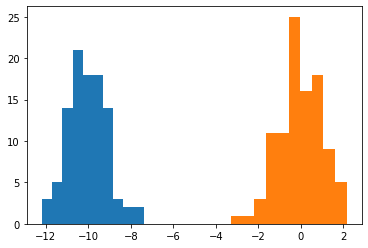

In [27]:
_ = plt.hist(x0[:, 0])
_ = plt.hist(xout[:, 0])

In [32]:
st = time.time()
xout2, log2 = svgd.adaptive_param_svgd(x0, logp, stepsize, L)
el = time.time() - st
print("elapsed time:", el)

elapsed time: 0.0015478134155273438


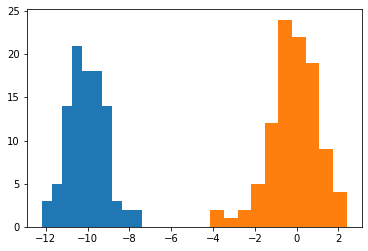

In [29]:
_ = plt.hist(x0[:, 0])
_ = plt.hist(xout2[:, 0])

Elapsed times:
* called for first time, nonjitted, n=100: both 80s
* called for first time, jitted, n=100: fixed 90s, adaptive 90s (+-10s)
* subsequent calls with same `x` data are extremely fast, but recompilation is triggered by reloading `logp`. Interesting, reloading `h` does not trigger recompilation. Upon checking, this is because reassigning `h` doesnt actually do anything to the `h` in memory, but reassigning `logp` to the same function does.
* called second time after `jit` compilation (after changing sampled input `x` (and/or bandwidth `h` in fixed param case) but nothing else): just as fast as with no change, on the order of 0.1-1 milliseconds.